# Imports

In [1]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import pandas as pd
import arff
import numpy as np
from imblearn.over_sampling import SMOTE
%matplotlib inline

# Load Data

In [2]:
# Load the data
data_freq = arff.load('data/raw/freMTPL2freq.arff') 
df_freq = pd.DataFrame(data_freq,  columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", 
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]) 

data_sev = arff.load('data/raw/freMTPL2sev.arff') 
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"]) 
df_sev = df_sev.groupby('IDpol')['ClaimAmount'].sum().reset_index()

# Merge datasets
df = pd.merge(df_freq, df_sev, on="IDpol", how="left")

# Create target variable (damage amount per year)
df['ClaimAmount'] = df['ClaimAmount'].fillna(0)
df['Target'] = df['ClaimAmount'] / df['Exposure']

labels = [0, 1, 2, 3, 4, 5, 6]
bins = [-1, 0, 5000, 10000, 15000, 25000, 50000, float('inf')]
df['TargetClass'] = pd.cut(df['Target'], bins=bins, labels=labels)


# Apply transformation
df_processed = df.drop(columns=['IDpol', 'ClaimAmount','Exposure', 'ClaimNb'])
df_processed = df_processed.sample(frac=1, random_state=42).reset_index(drop=True)

# Explorative Daten Analyse

In [3]:
print("Erste 5 Zeilen des DataFrames:")
print(df.head())

print("\nGrundlegende Statistiken:")
print(df.describe())

print("\nDatentypen:")
print(df.dtypes)

print("\nFehlende Werte:")
print(df.isnull().sum())

Erste 5 Zeilen des DataFrames:
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0      1.0      0.10  'D'       5.0     0.0     55.0        50.0   
1    3.0      1.0      0.77  'D'       5.0     0.0     55.0        50.0   
2    5.0      1.0      0.75  'B'       6.0     2.0     52.0        50.0   
3   10.0      1.0      0.09  'B'       7.0     0.0     46.0        50.0   
4   11.0      1.0      0.84  'B'       7.0     0.0     46.0        50.0   

  VehBrand   VehGas  Density Region  ClaimAmount  Target TargetClass  
0    'B12'  Regular   1217.0  'R82'          0.0     0.0           0  
1    'B12'  Regular   1217.0  'R82'          0.0     0.0           0  
2    'B12'   Diesel     54.0  'R22'          0.0     0.0           0  
3    'B12'   Diesel     76.0  'R72'          0.0     0.0           0  
4    'B12'   Diesel     76.0  'R72'          0.0     0.0           0  

Grundlegende Statistiken:
              IDpol        ClaimNb       Exposure       VehPower 

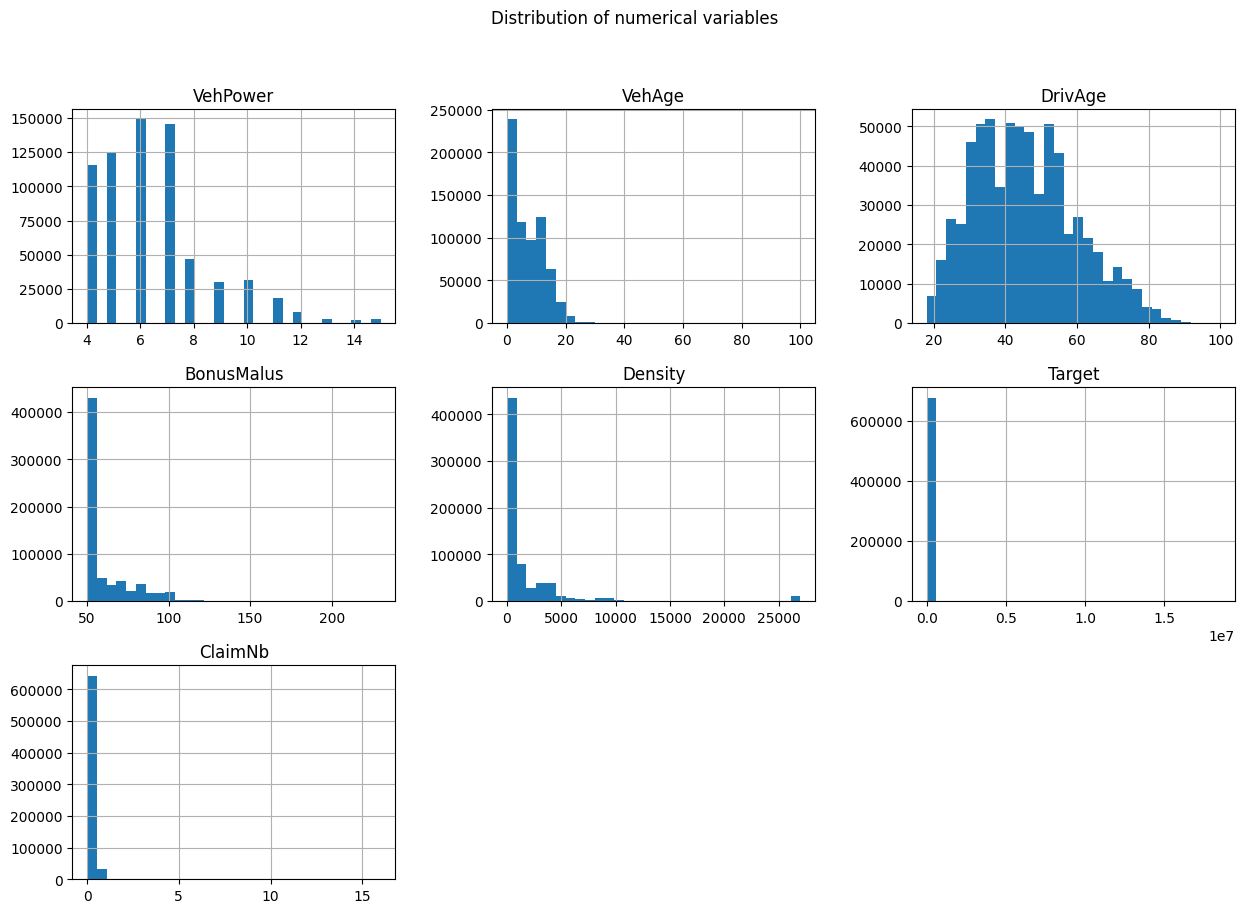

/var/folders/xx/yw34cppn2cv3kmh21dv6xcnw0000gp/T/ipykernel_80584/537429044.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_index].set_xticklabels(axes[row, col_index].get_xticklabels(), rotation=90)
/var/folders/xx/yw34cppn2cv3kmh21dv6xcnw0000gp/T/ipykernel_80584/537429044.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_index].set_xticklabels(axes[row, col_index].get_xticklabels(), rotation=90)
/var/folders/xx/yw34cppn2cv3kmh21dv6xcnw0000gp/T/ipykernel_80584/537429044.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_index].set_xticklabels(axes[row, col_index].get_xticklabels(), rotation=90)
/var/folders/xx/yw34cppn2cv3kmh21dv6xcnw0000gp/T/ipykernel_80584/537429044.py:17: UserWarning:

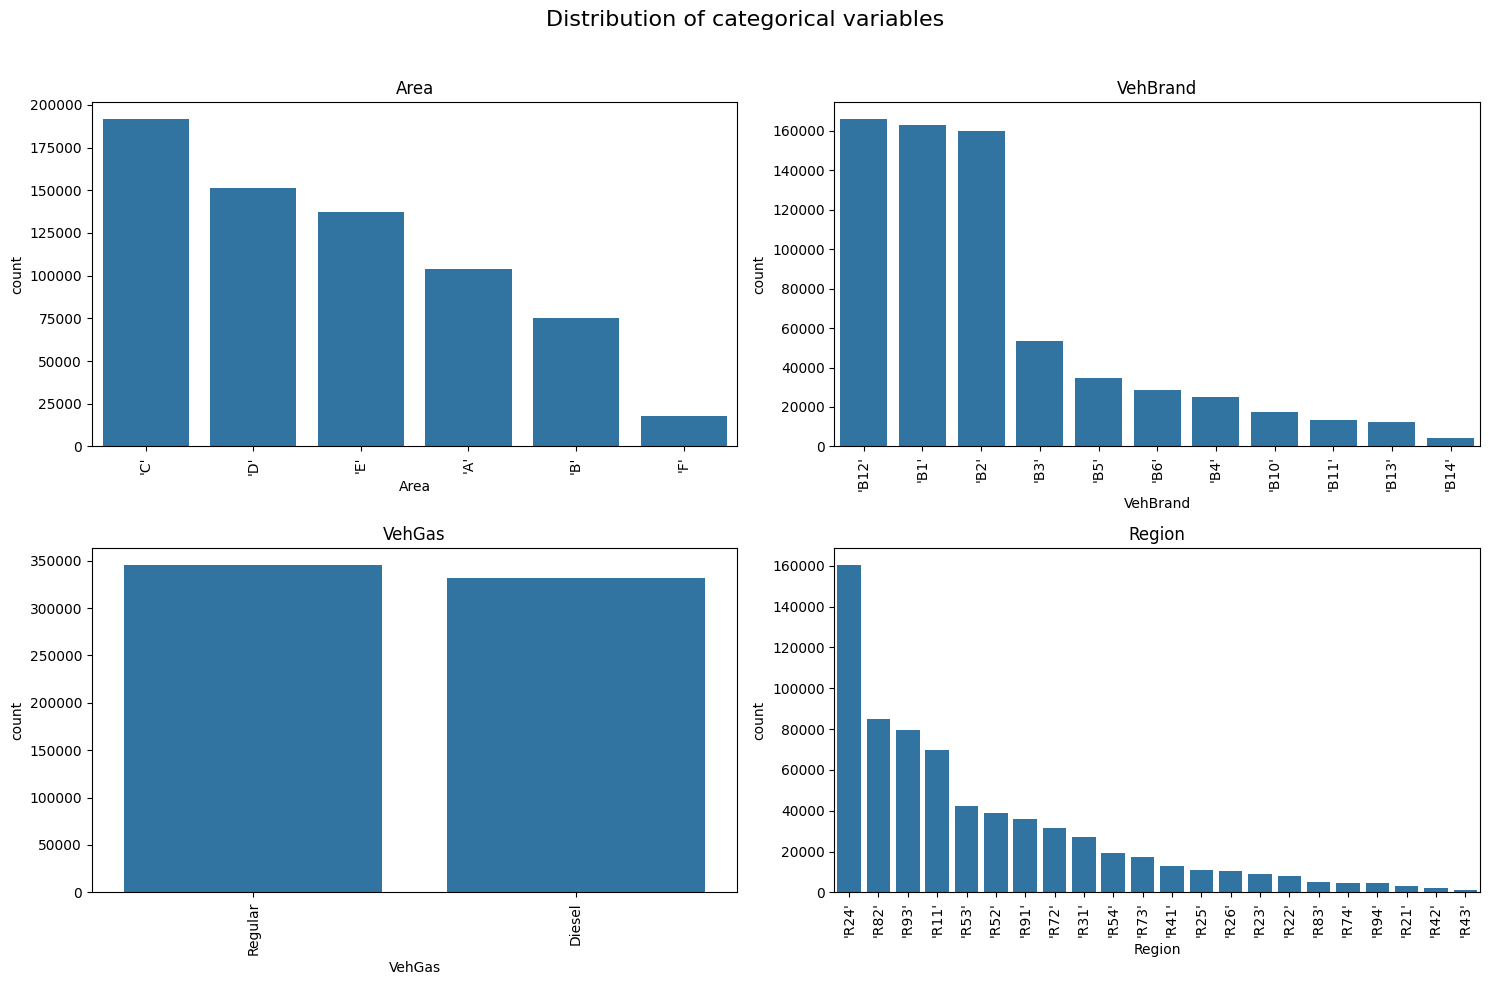

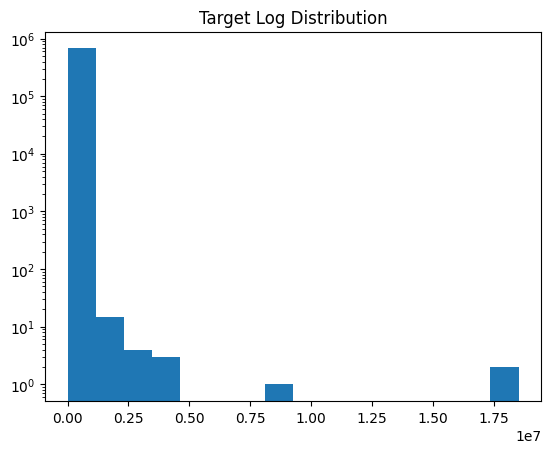

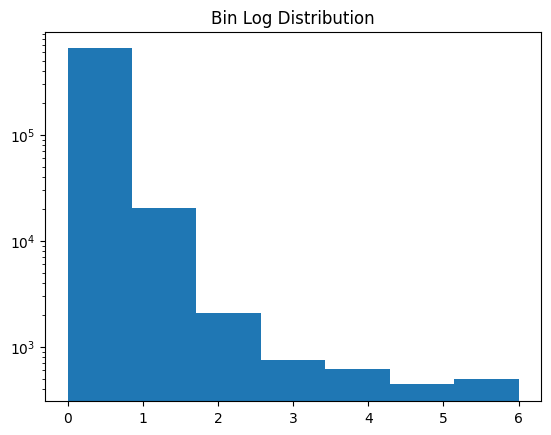

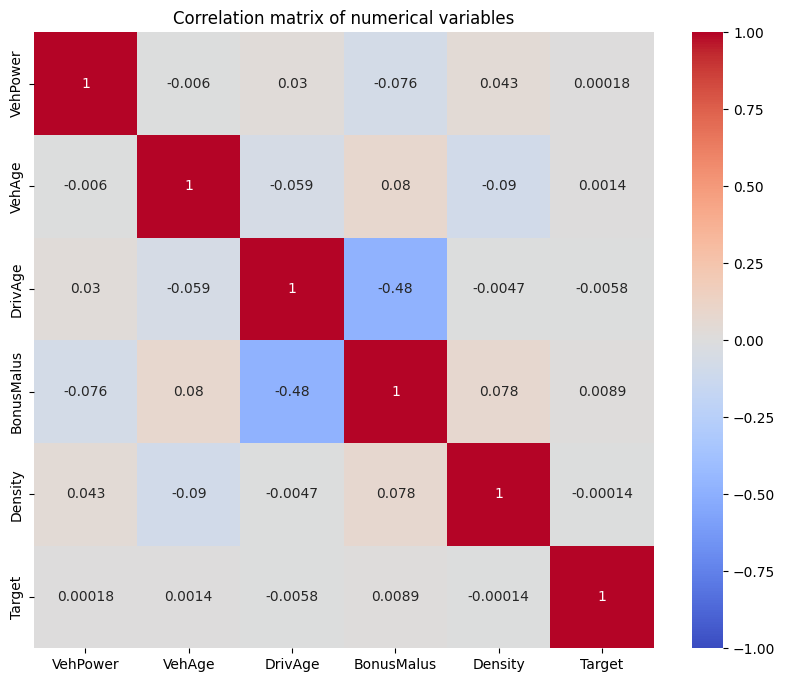

In [4]:
# Univariate analysis of numerical variables
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Target', 'ClaimNb']
df[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of numerical variables')
plt.show()

# Categorical variables
categorical_cols = ['Area', 'VehBrand', 'VehGas', 'Region']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribution of categorical variables', fontsize=16)

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_index = i % 2
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'{col}')
    axes[row, col_index].set_xticklabels(axes[row, col_index].get_xticklabels(), rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Log distribution of Target
plt.hist(df.Target, bins=16, log=True)
plt.title('Target Log Distribution')
plt.show()

# Log distribution of ClaimNb
plt.hist(df.TargetClass, log=True, bins=7)
plt.title('Bin Log Distribution')
plt.show()

# Correlation between numerical variables
plt.figure(figsize=(10, 8))
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Target']
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of numerical variables')
plt.show()


Key Findings:
- No missing values
- Outliners in target variable.
- No obvious Korrelation between the Target and the Features.
- Massive unbalancing in the target-variable (almost 96% 0-values).

- A regression will be difficult due to the nature of the data
    * A possible attampt could be a classification of different claimamount groups.

The idea:
- Use binning for the Target and predict claim groups

# Model and Training

In [5]:
# To prepare the data fot the training we need to create a train and a test set.
# Then we need to process the data using a scaler and a onehotencoder


numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_cols = ['Area', 'VehBrand', 'VehGas', 'Region']

# Split the data
# reduce dataset for faster testing
df_subsample, _ = train_test_split(df_processed, test_size=0.9, random_state=42, stratify=df_processed["TargetClass"])
df_train, df_test = train_test_split(df_subsample, test_size=0.2, random_state=42, stratify=df_subsample["TargetClass"])

# df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=42, stratify=df_processed["TargetClass"])

X_train = df_train.drop(columns=['TargetClass', 'Target'], axis=1)
y_train = df_train['TargetClass']
y_train_value = df_train['Target']

X_test = df_test.drop(columns=['TargetClass', 'Target'], axis=1)
y_test = df_test['TargetClass']
y_test_value = df_test['Target']

# Pipeline with preprocessing and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Uncomment to use SMOTE for balancing the data or use weight balance

# smote_enn = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train_transformed, y_train)
# Convert sparse matrix to dense format
# X_train_balanced = X_train_balanced.toarray()

# Shuffle the balanced data
# shuffled_indices = np.random.permutation(len(X_train_balanced))
# X_train_balanced = X_train_balanced[shuffled_indices]
# y_train_balanced = y_train_balanced[shuffled_indices]

# Use the transformed training data without balancing
X_train_balanced, y_train_balanced = X_train_transformed, y_train


Training Logistic Regression...
Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.14      0.24     52245
           1       0.05      0.16      0.08      1645
           2       0.01      0.24      0.01       166
           3       0.00      0.42      0.01        60
           4       0.00      0.43      0.01        49
           5       0.00      0.46      0.00        35
           6       0.00      0.55      0.01        40

    accuracy                           0.14     54240
   macro avg       0.15      0.34      0.05     54240
weighted avg       0.94      0.14      0.23     54240




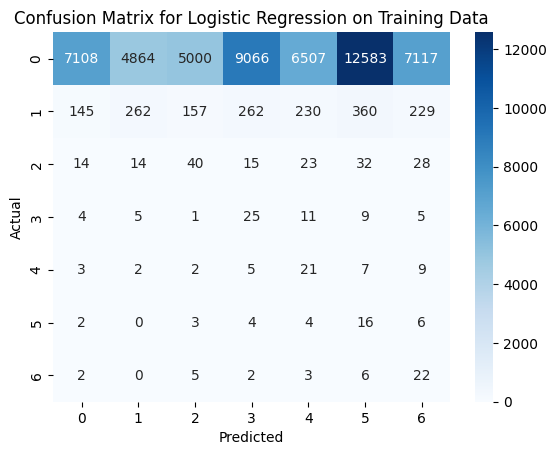

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.14      0.24     13062
           1       0.04      0.13      0.06       412
           2       0.00      0.12      0.01        41
           3       0.00      0.47      0.01        15
           4       0.00      0.42      0.01        12
           5       0.00      0.00      0.00         9
           6       0.00      0.10      0.00        10

    accuracy                           0.14     13561
   macro avg       0.15      0.20      0.05     13561
weighted avg       0.94      0.14      0.23     13561




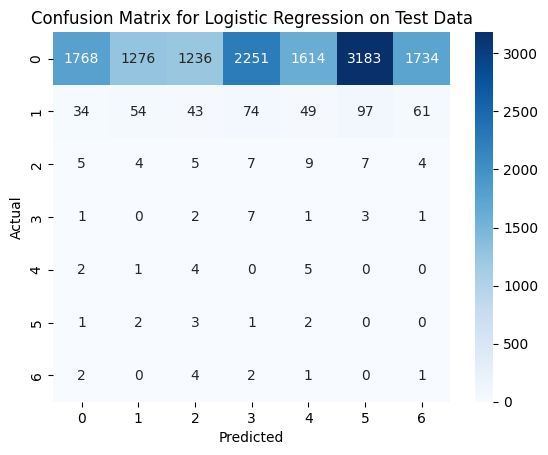

Training K-Nearest Neighbors...
Results for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     52245
           1       0.57      0.01      0.01      1645
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        49
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        40

    accuracy                           0.96     54240
   macro avg       0.22      0.14      0.14     54240
weighted avg       0.95      0.96      0.95     54240




/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

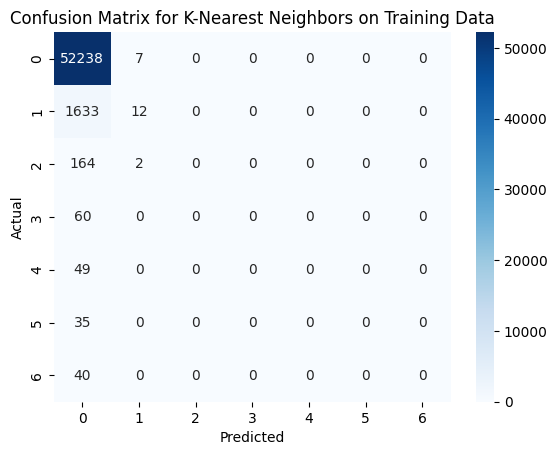

Results for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13062
           1       0.00      0.00      0.00       412
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10

    accuracy                           0.96     13561
   macro avg       0.14      0.14      0.14     13561
weighted avg       0.93      0.96      0.94     13561




/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

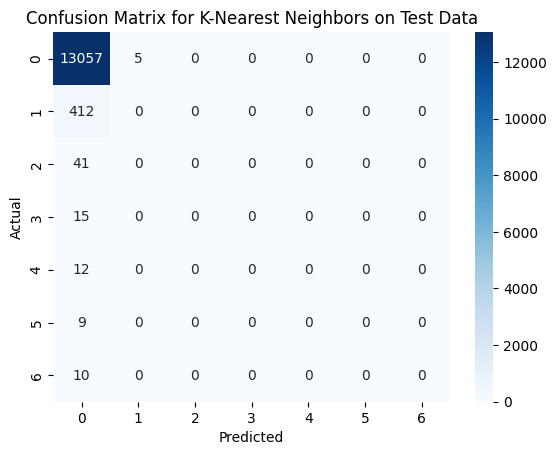

Training Decision Tree...
Results for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52245
           1       0.98      1.00      0.99      1645
           2       0.99      1.00      0.99       166
           3       0.92      1.00      0.96        60
           4       0.94      1.00      0.97        49
           5       1.00      1.00      1.00        35
           6       0.98      1.00      0.99        40

    accuracy                           1.00     54240
   macro avg       0.97      1.00      0.99     54240
weighted avg       1.00      1.00      1.00     54240




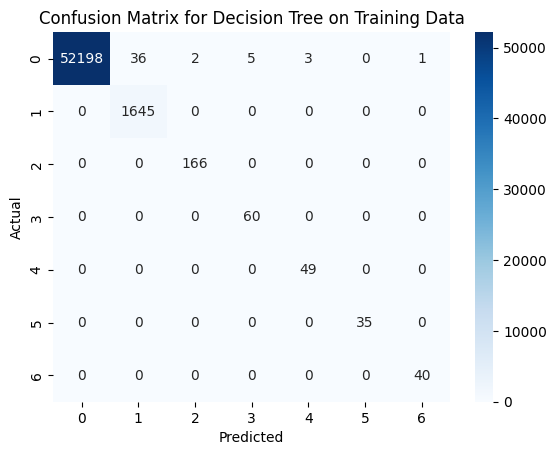

Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     13062
           1       0.04      0.05      0.04       412
           2       0.03      0.05      0.04        41
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10

    accuracy                           0.92     13561
   macro avg       0.15      0.15      0.15     13561
weighted avg       0.93      0.92      0.92     13561




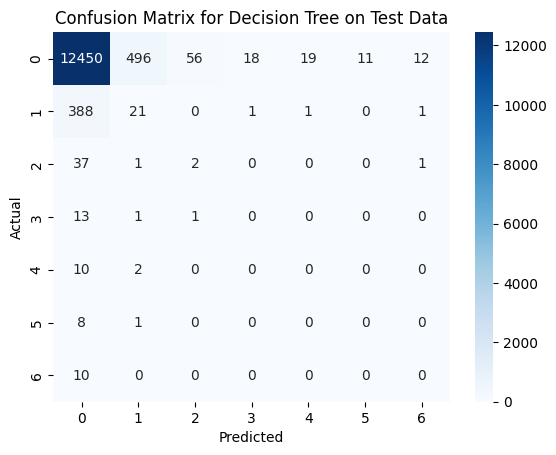

Training Random Forest...
Results for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52245
           1       1.00      0.98      0.99      1645
           2       1.00      0.99      0.99       166
           3       1.00      0.92      0.96        60
           4       1.00      0.96      0.98        49
           5       1.00      1.00      1.00        35
           6       1.00      0.97      0.99        40

    accuracy                           1.00     54240
   macro avg       1.00      0.97      0.99     54240
weighted avg       1.00      1.00      1.00     54240




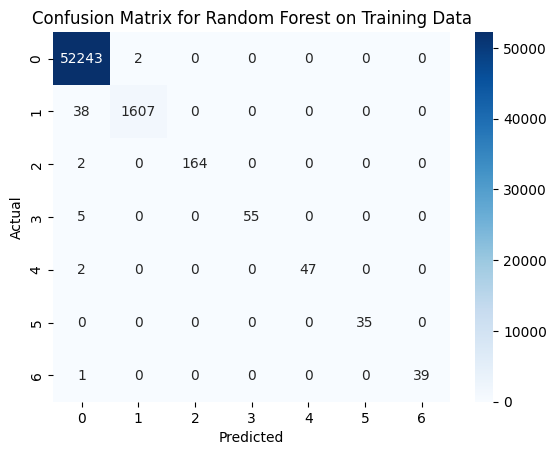

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13062
           1       0.08      0.00      0.01       412
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10

    accuracy                           0.96     13561
   macro avg       0.15      0.14      0.14     13561
weighted avg       0.93      0.96      0.94     13561




/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fynnersatz/Desktop/python/git/Huk_code_challenge/challengeVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

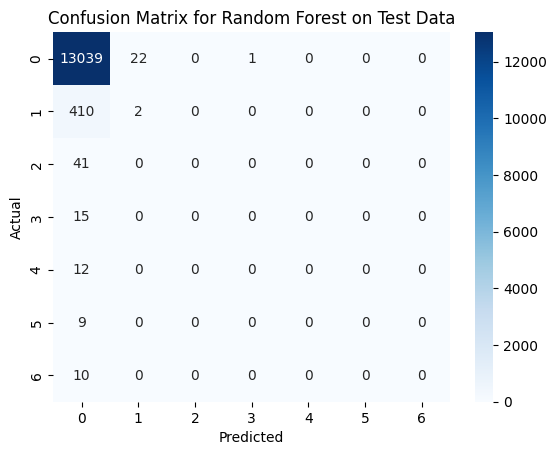

In [6]:
# First we test multiple models to out which is able to learn from the data

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42), 
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_train_balanced)
    
    # Evaluate the model on training data
    print(f"Results for {name}:")
    print(classification_report(y_train_balanced, y_pred))
    cm = confusion_matrix(y_train_balanced, y_pred)

    print()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name} on Training Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Evaluate the model on test data
    y_pred = model.predict(X_test_transformed)
    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name} on Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# it showed that the randomforrest can learn the data best but it overfits on the training data. This has to be fixed.